running simulation [...]


WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "GCB1InhExc_post += (rand() < 0.2) * w (in-place)"
 [brian2.codegen.generators.base]


-> done !


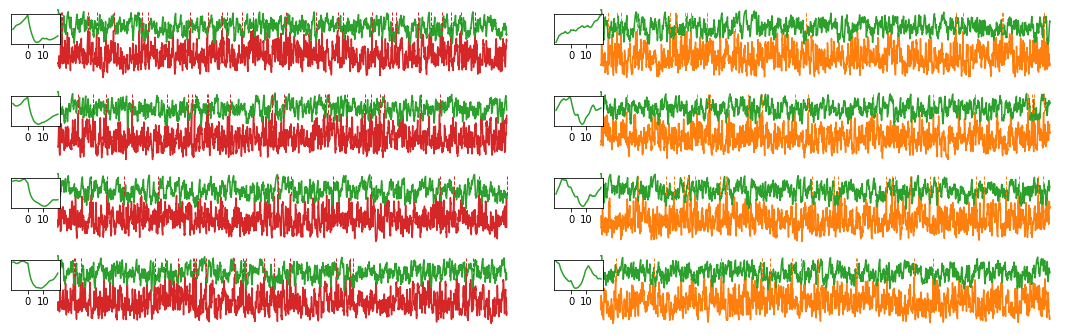

In [3]:
from Model import *

# removing exc and pushing 
Model['tstop'] = 10000
Model['Q_Exc_Exc'] = 0.01
Model['Q_AffExc_Exc'] = 0.01
Model['F_AffExc'] = 10
Model['Exc_El'] = -52 # pushing rest level up to see inh. better

run_single_sim(Model, filename='checking_pairs.h5')
data = ntwk.recording.load_dict_from_hdf5('checking_pairs.h5')
plot_Vm_pairs(data);

# Modeling the effect of CB1-signalling

In [1]:
import os
import numpy as np
import matplotlib.pylab as plt

import sys, pathlib
sys.path.append(os.path.join(os.path.expanduser('~'), 'work', 'neural_network_dynamics'))

import main as ntwk

In [2]:
# starting config

## V1 model

In [3]:
Model_V1 = {
    ## -----------------------------------------------------------------------
    ### Initialisation by default parameters
    ## UNIT SYSTEM is : ms, mV, pF, nS, pA, Hz (arbitrary and unconsistent, so see code)
    ## -----------------------------------------------------------------------

    # numbers of neurons in population
    'N_Exc':4000, 'N_Inh':1000, 'N_AffExc':100, 'N_DsInh':500,
    # synaptic weights
    'Q_Exc_Exc':2., 'Q_Exc_Inh':2., 
    'Q_Inh_Exc':10., 'Q_Inh_Inh':10., 
    'Q_AffExc_Exc':4., 'Q_AffExc_Inh':4., 
    'Q_AffExc_DsInh':4.,
    'Q_DsInh_Inh':10., 
    # synaptic time constants
    'Tse':5., 'Tsi':5.,
    # synaptic reversal potentials
    'Ee':0., 'Ei': -80.,
    # connectivity parameters
    'p_Exc_Exc':0.05, 'p_Exc_Inh':0.05, 
    'p_Inh_Exc':0.05, 'p_Inh_Inh':0.05, 
    'p_AffExc_Exc':0.1, 'p_AffExc_Inh':0.1, 
    'p_AffExc_DsInh':0.,
    'p_DsInh_Inh':0.05, 
    # afferent stimulation (0 by default)
    'F_AffExc':0., 'F_DsInh':0.,
    # simulation parameters
    'dt':0.1, 'tstop': 1000., 'SEED':3, # low by default, see later
    ## ---------------------------------------------------------------------------------
    # === cellular properties (based on AdExp), population by population ===
    # --> Excitatory population (Exc, recurrent excitation)
    'Exc_Gl':1
    0., 'Exc_Cm':200.,'Exc_Trefrac':5.,
    'Exc_El':-70., 'Exc_Vthre':-50., 'Exc_Vreset':-70., 'Exc_deltaV':0.,
    'Exc_a':0., 'Exc_b': 0., 'Exc_tauw':1e9,
    # --> Inhibitory population (Inh, recurrent inhibition)
    'Inh_Gl':10., 'Inh_Cm':200.,'Inh_Trefrac':5.,
    'Inh_El':-70., 'Inh_Vthre':-53., 'Inh_Vreset':-70., 'Inh_deltaV':0.,
    'Inh_a':0., 'Inh_b': 0., 'Inh_tauw':1e9,
    # --> Disinhibitory population (DsInh, disinhibition)
    'DsInh_Gl':10., 'DsInh_Cm':200.,'DsInh_Trefrac':5.,
    'DsInh_El':-70., 'DsInh_Vthre':-50., 'DsInh_Vreset':-70., 'DsInh_deltaV':0.,
    'DsInh_a':0., 'DsInh_b': 0., 'DsInh_tauw':1e9
}

In [4]:
Model_V1['tstop'], Model_V1['dt'] = 3000, 0.1

# build recurrent network
NTWK_V1 = ntwk.build_populations(Model_V1, ['Exc', 'Inh'],
                                 AFFERENT_POPULATIONS=['AffExc'],
                                 with_raster=True, with_Vm=4)
ntwk.build_up_recurrent_connections(NTWK_V1, SEED=5)

# afferent activity onto cortical excitation and inhibition
faff = 5.
t_array = ntwk.arange(int(Model_V1['tstop']/Model_V1['dt']))*Model_V1['dt']
# # afferent excitation 
for i, tpop in enumerate(['Exc', 'Inh']): # both on excitation and inhibition
    ntwk.construct_feedforward_input(NTWK_V1, tpop, 'AffExc',
                                     t_array, faff+0.*t_array)

        
ntwk.initialize_to_rest(NTWK_V1)
V1_sim = ntwk.collect_and_run(NTWK_V1, verbose=True)
ntwk.write_as_hdf5(NTWK_V1, filename='V1_spont.h5')

running simulation [...]
-> done !


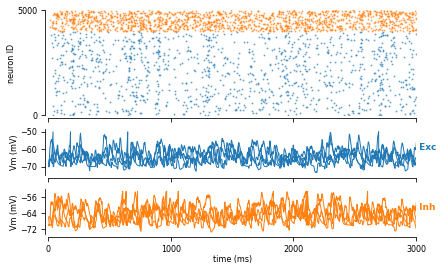

In [12]:
data = ntwk.load_dict_from_hdf5('V1_spont.h5')
fig, _ = ntwk.raster_and_Vm_plot(data)

## V2 model,reducing IN->PN interaction by playing on synaptic weights

In [15]:
# reduction factor
factor = 1.5

Model_V2 = Model_V1.copy()
for key in ['Q_Inh_Exc']:
    Model_V2[key] = Model_V1[key]/factor

In [16]:
# build recurrent network
NTWK_V2 = ntwk.build_populations(Model_V2, ['Exc', 'Inh'],
                                 AFFERENT_POPULATIONS=['AffExc'],
                                 with_raster=True, with_Vm=4)
ntwk.build_up_recurrent_connections(NTWK_V2, SEED=5)

# afferent activity onto cortical excitation and inhibition
for i, tpop in enumerate(['Exc', 'Inh']): # both on excitation and inhibition
    ntwk.construct_feedforward_input(NTWK_V2, tpop, 'AffExc',
                                     t_array, faff+0.*t_array)

        
ntwk.initialize_to_rest(NTWK_V2)
V2_sim = ntwk.collect_and_run(NTWK_V2, verbose=True)
ntwk.write_as_hdf5(NTWK_V2, filename='V2_spont.h5')

running simulation [...]
-> done !


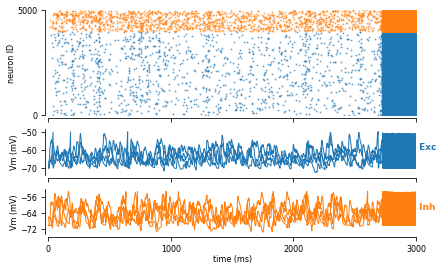

In [17]:
data = ntwk.load_dict_from_hdf5('V2_spont.h5')
fig, _ = ntwk.raster_and_Vm_plot(data)

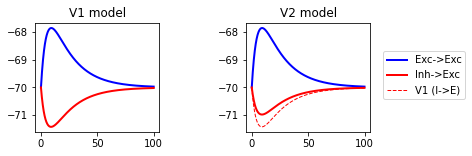

In [50]:

#########################################################
####### PSP associated to each synaptic connection ######
#########################################################

def psp(Model, nrn_pre, nrn_post, Ts, Erev, dt=0.1, t0=10, tstop=100):
    Cm, Gl, El = Model[nrn_post+'_Cm'], Model[nrn_post+'_Gl'], Model[nrn_post+'_El']
    t = np.arange(int(tstop/dt))*dt
    Q = Model['Q_'+nrn_pre+'_'+nrn_post]
    g = np.array([Q*np.exp(-tt/Ts) if tt>0 else 0 for tt in t])
    v = [El]
    for i in range(1, len(t)):
        v.append(v[i-1]+dt/Cm*(g[i]*(Erev-v[i-1])+Gl*(El-v[i-1])))
    return t, np.array(v)

fig, AX = plt.subplots(1,2, figsize=(6,2))
plt.subplots_adjust(wspace=.7)
AX[0].set_title('V1 model')
AX[1].set_title('V2 model')
#for i, presyn, Erev, c in zip(range(3), ['AffExc', 'Exc', 'Inh'], [0, 0, -80], ['grey', 'b','r']):
for i, presyn, Erev, c in zip(range(2), ['Exc', 'Inh'], [0, -80], ['b','r']):
    AX[0].plot(*psp(Model_V1, presyn, 'Exc', 5, Erev), '-', lw=2, color=c)
    AX[1].plot(*psp(Model_V2, presyn, 'Exc', 5, Erev), '-', lw=2, color=c, label='%s->Exc' % presyn)
AX[1].plot(*psp(Model_V1, 'Inh', 'Exc', 5, Erev), '--', lw=1, color='r', label='V1 (I->E)')
#plt.plot([60,60], [-68,-66], lw=2, color='grey')
#plt.annotate("2mV", (70, -67), fontsize=10)
#plt.plot([60,80], [-68,-68], lw=2, color='grey')
#plt.annotate("20ms", (70, -69.5), fontsize=10)
AX[1].legend(loc=(1.1,.3))